In [132]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [133]:
#data from: https://www.kaggle.com/adamschroeder/crimes-new-york-city/data
crimeData=pd.read_csv(os.getcwd()+'/data/NYPD_Complaint_Data_Historic.csv')
#http://www1.nyc.gov/site/nypd/stats/reports-analysis/stopfrisk.page
stopfriskData=pd.read_csv(os.getcwd()+'/data/stop_frisk_2015.csv')

/home/ben/anaconda3/envs/insight/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [134]:
stopfriskData.head()

,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,crimsusp,...,zip,addrpct,sector,beat,post,xcoord,ycoord,dettypCM,lineCM,detailCM
0,2015,61,18,1012015,315,1,O,P,2.0,FELONY,...,,61,E,7,,1000091,156314,CM,1,14
1,2015,22,5,1152015,1747,A,O,P,1.0,FELONY,...,,22,E,14,,994617,227693,CM,1,20
2,2015,20,36,1292015,1745,1,O,P,1.0,MISD,...,,20,H,,16,991510,225019,CM,1,78
3,2015,20,38,1292015,1745,1,O,P,1.0,MIDS,...,,20,H,,16,991510,225019,CM,1,78
4,2015,20,41,1292015,1745,1,O,P,1.0,MISD,...,,20,H,,16,991510,225019,CM,1,78


## Let's convert the coordinate data from stopfristData to latitude longitude

In [160]:
from pyproj import Proj
pnyc = Proj(
    proj='lcc',
    datum='NAD83',
    lat_1=40.666667,
    lat_2=41.033333,
    lat_0=40.166667,
    lon_0=-74.0,
    x_0=984250.0,
    y_0=0.0,
    preserve_units=True)
#lon, lat = pnyc(x, y, inverse=True)
#print(lon)
#print(lat)

'\n    lat_1=40.666667,\n    lat_2=41.033333,\n    lat_0=40.166667,\n    lon_0=-74.0,\n    x_0=984250.0,\n    y_0=0.0\n'

In [161]:
xstopfrisk=list()
ystopfrisk=list()
counter=0
baddatacounter=0
baddata=list()
for i in stopfriskData.index:
    try:
        x,y=pnyc(float(stopfriskData['xcoord'][i]), float(stopfriskData['ycoord'][i]), inverse=True)
        xstopfrisk.append(x)
        ystopfrisk.append(y)
    except:
        print(stopfriskData['xcoord'][i])
        print(stopfriskData['ycoord'][i])
        print(counter)
        baddatacounter+=1
        baddata.append(counter)

    counter+=1

In [162]:
stopfriskData.drop(stopfriskData.index[baddata],inplace=True)
stopfriskData['Longitude']=pd.Series(xstopfrisk,index=stopfriskData.index)
stopfriskData['Latitude']=pd.Series(ystopfrisk,index=stopfriskData.index)

In [163]:
stopfriskData.head()

,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,crimsusp,...,sector,beat,post,xcoord,ycoord,dettypCM,lineCM,detailCM,Longitude,Latitude
0,2015,61,18,1012015,315,1,O,P,2.0,FELONY,...,E,7,,1000091,156314,CM,1,14,7.374717,0.854039
1,2015,22,5,1152015,1747,A,O,P,1.0,FELONY,...,E,14,,994617,227693,CM,1,20,7.377165,1.386346
2,2015,20,36,1292015,1745,1,O,P,1.0,MISD,...,H,,16,991510,225019,CM,1,78,7.352619,1.368350
3,2015,20,38,1292015,1745,1,O,P,1.0,MIDS,...,H,,16,991510,225019,CM,1,78,7.352619,1.368350
4,2015,20,41,1292015,1745,1,O,P,1.0,MISD,...,H,,16,991510,225019,CM,1,78,7.352619,1.368350


In [164]:
from sklearn.cluster import KMeans
KMmodel=KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300)
stopfriskCluster=KMmodel.fit(stopfriskData[['Longitude','Latitude']])
print(stopfriskCluster.cluster_centers_)

[[ 7.58599361  1.5544832 ]
 [ 7.36296063  1.26760199]
 [ 7.63859097  1.03259122]
 [ 6.998589    0.92714304]
 [ 7.309413    0.91767066]
 [ 7.40105451  1.06662974]
 [ 7.46055201  1.44332263]
 [ 7.6850093   1.19290507]]


In [165]:
import folium
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="CartoDB dark_matter")
#marker = folium.CircleMarker(location=[40.738, -73.98])
#marker.add_to(folium_map)
color="#0A8A9F" #teal
for i in stopfriskCluster.cluster_centers_:
    folium.CircleMarker(location=(i[0],
                                  i[1]),
                        radius=1,
                        color=color,
                        fill=True).add_to(folium_map)
'''
import folium
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="CartoDB dark_matter")
#marker = folium.CircleMarker(location=[40.738, -73.98])
#marker.add_to(folium_map)
color="#0A8A9F" #teal
for index, row in stopfriskData.iterrows():
    folium.CircleMarker(location=(row["Latitude"],
                                  row["Longitude"]),
                        radius=1,
                        color=color,
                        fill=True).add_to(folium_map)
color="#E37222" # tangerine
for index, row in homicideData.iterrows():
    folium.CircleMarker(location=(row["Latitude"],
                                  row["Longitude"]),
                        radius=1,
                        color=color,
                        fill=True).add_to(folium_map)
'''


'\nimport folium\nfolium_map = folium.Map(location=[40.738, -73.98],\n                        zoom_start=13,\n                        tiles="CartoDB dark_matter")\n#marker = folium.CircleMarker(location=[40.738, -73.98])\n#marker.add_to(folium_map)\ncolor="#0A8A9F" #teal\nfor index, row in stopfriskData.iterrows():\n    folium.CircleMarker(location=(row["Latitude"],\n                                  row["Longitude"]),\n                        radius=1,\n                        color=color,\n                        fill=True).add_to(folium_map)\ncolor="#E37222" # tangerine\nfor index, row in homicideData.iterrows():\n    folium.CircleMarker(location=(row["Latitude"],\n                                  row["Longitude"]),\n                        radius=1,\n                        color=color,\n                        fill=True).add_to(folium_map)\n'

In [153]:
folium_map

In [109]:
stopfriskData.shape

(22563, 112)

In [88]:
crimeData.drop(['Lat_Lon','X_COORD_CD','Y_COORD_CD'],axis=1,inplace=True)
crimeData=crimeData[crimeData['BORO_NM']=='MANHATTAN']
#crimeData.keys()

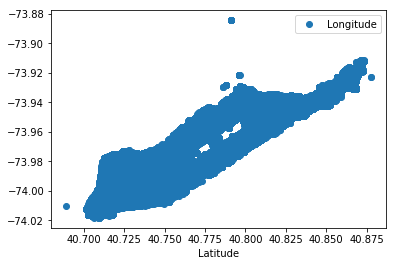

In [89]:
crimeData.plot(x='Latitude', y='Longitude', style='o')

In [90]:
crimeData.head()
crimeData.dropna(subset=['OFNS_DESC'],axis=0,inplace=True) 

In [99]:
murderData=crimeData[crimeData['OFNS_DESC'].str.contains("MURDER")][['Latitude','Longitude']]
homicideData=crimeData[crimeData['OFNS_DESC'].str.contains("HOMICIDE")]
assaultData=crimeData[crimeData['OFNS_DESC'].str.contains("ASSAULT")]
assaultData.dropna(subset=['Latitude'],axis=0,inplace=True)
assaultData.dropna(subset=['Longitude'],axis=0,inplace=True)
assaultData.head()

/home/ben/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/ben/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,LAW_CAT_CD,JURIS_DESC,BORO_NM,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,Latitude,Longitude
4,641637920,12/31/2015,23:25:00,12/31/2015,23:30:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,MISDEMEANOR,N.Y. POLICE DEPT,MANHATTAN,13.0,FRONT OF,OTHER,NaN,NaN,40.738002,-73.987891
34,590638275,12/31/2015,22:30:00,NaN,NaN,12/31/2015,106,FELONY ASSAULT,109.0,"ASSAULT 2,1,UNCLASSIFIED",...,FELONY,N.Y. POLICE DEPT,MANHATTAN,13.0,NaN,PARK/PLAYGROUND,MADISON SQUARE PARK,NaN,40.742781,-73.986598
49,372582288,12/31/2015,22:00:00,12/31/2015,22:19:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,MISDEMEANOR,N.Y. HOUSING POLICE,MANHATTAN,7.0,INSIDE,RESIDENCE - PUBLIC HOUSING,NaN,LA GUARDIA,40.711565,-73.988343
54,834212518,12/31/2015,22:00:00,12/31/2015,22:19:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,MISDEMEANOR,N.Y. HOUSING POLICE,MANHATTAN,7.0,INSIDE,RESIDENCE - PUBLIC HOUSING,NaN,LA GUARDIA,40.711565,-73.988343
63,124480034,12/31/2015,21:45:00,NaN,NaN,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,MISDEMEANOR,N.Y. POLICE DEPT,MANHATTAN,13.0,FRONT OF,STREET,NaN,NaN,40.736691,-73.995231


In [92]:
murderData.head()

,Latitude,Longitude
3583,40.810877,-73.941064
57962,40.867233,-73.920916
66374,40.752863,-73.992981
82048,40.800385,-73.954701
92513,40.796749,-73.929194


In [141]:
#folium_map

In [70]:
murderData['KY_CD'].unique()

array([101])

In [83]:
crimeData.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,LAW_CAT_CD,JURIS_DESC,BORO_NM,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,Latitude,Longitude
2,569369778,12/31/2015,23:30:00,NaN,NaN,12/31/2015,117,DANGEROUS DRUGS,503.0,"CONTROLLED SUBSTANCE,INTENT TO",...,FELONY,N.Y. POLICE DEPT,MANHATTAN,28.0,NaN,OTHER,NaN,NaN,40.802607,-73.945052
4,641637920,12/31/2015,23:25:00,12/31/2015,23:30:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,MISDEMEANOR,N.Y. POLICE DEPT,MANHATTAN,13.0,FRONT OF,OTHER,NaN,NaN,40.738002,-73.987891
6,608231454,12/31/2015,23:15:00,NaN,NaN,12/31/2015,235,DANGEROUS DRUGS,511.0,"CONTROLLED SUBSTANCE, POSSESSI",...,MISDEMEANOR,N.Y. POLICE DEPT,MANHATTAN,7.0,OPPOSITE OF,STREET,NaN,NaN,40.720200,-73.988735
9,415095955,12/31/2015,23:10:00,12/31/2015,23:10:00,12/31/2015,341,PETIT LARCENY,338.0,"LARCENY,PETIT FROM BUILDING,UN",...,MISDEMEANOR,N.Y. POLICE DEPT,MANHATTAN,19.0,INSIDE,DRUG STORE,NaN,NaN,40.765618,-73.963623
11,178090167,12/31/2015,23:00:00,12/31/2015,23:05:00,12/31/2015,341,PETIT LARCENY,338.0,"LARCENY,PETIT FROM BUILDING,UN",...,MISDEMEANOR,N.Y. POLICE DEPT,MANHATTAN,13.0,INSIDE,RESTAURANT/DINER,NaN,NaN,40.732828,-73.986063


In [ ]:
'''


'''


for index, row in trip_counts.iterrows():
    net_departures = (row["Departure Count"]-row["Arrival Count"])
    radius = net_departures/20
    if net_departures>0:
        color="#E37222" # tangerine
    else:
        color="#0A8A9F" # teal
    
    folium.CircleMarker(location=(row["Start Station Latitude"],
                                  row["Start Station Longitude"]),
                        radius=radius,
                        color=color,
                        fill=True).add_to(folium_map)

# Stuff that is not working below

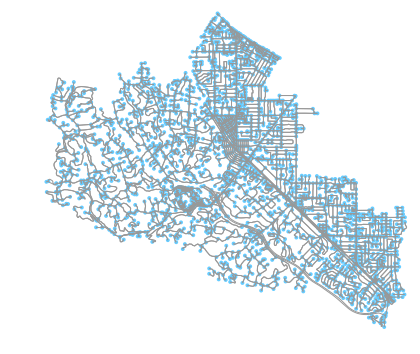

(<matplotlib.figure.Figure at 0x7f1aeab58978>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1aeab50630>)

In [21]:
import matplotlib.pyplot as plt
import osmnx as ox
places = ['Los Altos, California, USA',
          {'city':'Los Altos Hills', 'state':'California'},
          'Loyola, California']
G = ox.graph_from_place(places, network_type='drive')
ox.plot_graph(G)

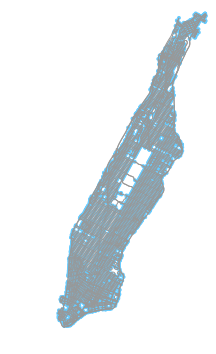

(<matplotlib.figure.Figure at 0x7f1aeb709d68>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1aeb709668>)

In [15]:
import osmnx as ox
G = ox.graph_from_place('Manhattan Island, New York City, New York, USA', network_type='drive')
ox.plot_graph(ox.project_graph(G))

In [16]:
DATASETS_URL = "https://github.com/ageron/handson-ml/raw/master/datasets"
import os
import tarfile
from six.moves import urllib

HOUSING_PATH = "datasets/housing"
HOUSING_URL = DATASETS_URL + "/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.exists(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [17]:
fetch_housing_data()
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


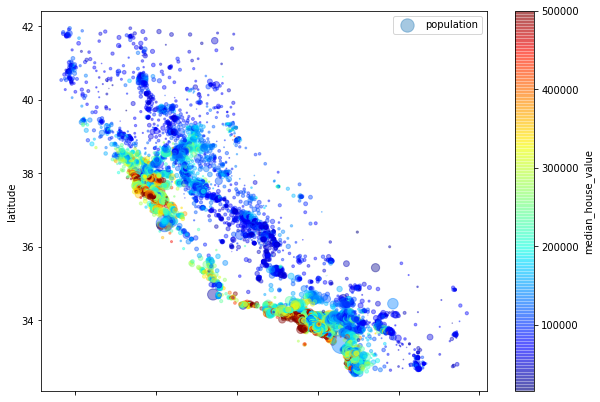

In [18]:
housing.plot(kind="scatter", x="longitude", y="latitude",
    s=housing['population']/100, label="population",
    c="median_house_value", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7),
)
plt.legend()
plt.show()

In [19]:
import geopandas as gpd

# File path
points_fp = r"/home/ben/Dropbox/Insight/Elucd/shapefiles/manhattan/MNMapPLUTO.shp"

# Read the data
points = gpd.read_file(points_fp)

In [20]:
points.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area,geometry
0,MN,1545,52,108,138,4000,02,5,10028,E022,...,0.000000e+00,None,1,None,None,17V1.1,0,260.428942,2867.154706,"POLYGON ((997277.2344000041 221816.0936000049,..."
1,MN,723,7501,104,93,6000,02,3,10001,E003,...,1.007230e+09,11/30/2006,1,None,None,17V1.1,7,417.764545,10907.639931,"POLYGON ((984164.5626000017 211846.0703999996,..."
2,MN,1680,48,111,170,5000,04,8,10029,E091,...,0.000000e+00,None,1,1,1,17V1.1,0,256.893308,2665.033424,"POLYGON ((1000742.195800006 227910.6640000045,..."
3,MN,1385,32,108,130,2003,02,4,10021,E039,...,0.000000e+00,None,1,None,None,17V1.1,0,505.033271,15302.920916,"POLYGON ((994007.6886000037 219880.428399995, ..."
4,MN,1197,27,107,169,5000,03,6,10024,E074,...,0.000000e+00,None,1,None,None,17V1.1,0,295.652483,4374.612455,"POLYGON ((992273.6850000024 224863.4904000014,..."
